# Import data

In [ ]:
!pip install scikit-learn-extra

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances, confusion_matrix, davies_bouldin_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.cluster import homogeneity_completeness_v_measure 
import seaborn as sns

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = "/content/gdrive/MyDrive/Universidade/ADAR - Projeto 1/Data/features.csv"
features = pd.read_csv(path, sep=',')

sleepstage = features[["sleepstage"]]
features = features.drop(columns=['sleepstage'])

n_features = features.shape[1]
features_names = list(features.columns.values)

features.head()

,Fp2-F4_0_energy,Fp2-F4_1_energy,Fp2-F4_2_energy,Fp2-F4_3_energy,Fp2-F4_4_energy,Fp2-F4_5_energy,Fp2-F4_6_energy,F4-C4_0_energy,F4-C4_1_energy,F4-C4_2_energy,F4-C4_3_energy,F4-C4_4_energy,F4-C4_5_energy,F4-C4_6_energy,C4-P4_0_energy,C4-P4_1_energy,C4-P4_2_energy,C4-P4_3_energy,C4-P4_4_energy,C4-P4_5_energy,C4-P4_6_energy,P4-O2_0_energy,P4-O2_1_energy,P4-O2_2_energy,P4-O2_3_energy,P4-O2_4_energy,P4-O2_5_energy,P4-O2_6_energy,F8-T4_0_energy,F8-T4_1_energy,F8-T4_2_energy,F8-T4_3_energy,F8-T4_4_energy,F8-T4_5_energy,F8-T4_6_energy,T4-T6_0_energy,T4-T6_1_energy,T4-T6_2_energy,T4-T6_3_energy,T4-T6_4_energy,...,F3-C3_2_var,F3-C3_3_var,F3-C3_4_var,F3-C3_5_var,F3-C3_6_var,C3-P3_0_var,C3-P3_1_var,C3-P3_2_var,C3-P3_3_var,C3-P3_4_var,C3-P3_5_var,C3-P3_6_var,P3-O1_0_var,P3-O1_1_var,P3-O1_2_var,P3-O1_3_var,P3-O1_4_var,P3-O1_5_var,P3-O1_6_var,F7-T3_0_var,F7-T3_1_var,F7-T3_2_var,F7-T3_3_var,F7-T3_4_var,F7-T3_5_var,F7-T3_6_var,T3-T5_0_var,T3-T5_1_var,T3-T5_2_var,T3-T5_3_var,T3-T5_4_var,T3-T5_5_var,T3-T5_6_var,C4-A1_0_var,C4-A1_1_var,C4-A1_2_var,C4-A1_3_var,C4-A1_4_var,C4-A1_5_var,C4-A1_6_var
0,-0.070346,-0.576699,-0.708301,-0.819052,-0.708285,-0.011141,0.032298,0.872485,-0.610477,-0.712635,-0.913971,-0.162508,0.023329,-0.067182,0.176605,-0.697963,-0.798760,-0.703826,1.601005,1.647061,0.312918,0.053630,-0.648834,-0.733861,-0.484400,1.687683,1.758053,0.413169,0.826067,-0.646544,-0.679254,-0.911371,0.830696,0.110530,-0.196434,-0.102736,-0.645383,-0.731148,-0.510150,1.705064,...,-0.709395,-0.991570,-0.338860,-0.274639,-0.310724,-0.587515,-0.692183,-0.807464,-0.637801,1.521384,1.357628,0.093112,-0.506660,-0.611122,-0.690715,-0.410091,1.622600,1.533977,0.188305,-0.200764,-0.595399,-0.645619,-0.876462,1.295449,-0.029820,-0.253670,-0.473581,-0.654653,-0.713038,-0.413638,1.723238,1.190887,-0.066577,-0.446887,-0.620835,-0.709865,-0.513406,1.412097,0.860194,-0.018808
1,0.541611,-0.628082,-0.737505,-0.728378,-0.600412,0.038014,0.016307,0.067727,-0.620114,-0.668291,-0.747070,1.209547,0.831913,0.110733,-0.742854,-0.692714,-0.767584,-0.407409,2.176654,2.710026,0.555618,-0.791906,-0.673276,-0.693268,-0.157880,2.098356,2.945680,0.750345,-0.246370,-0.643502,-0.705701,-0.742679,1.894097,0.406488,-0.170534,-0.631539,-0.683835,-0.695769,-0.097191,2.182184,...,-0.699783,-0.777108,0.519661,0.025767,-0.223062,-0.582862,-0.695196,-0.737704,-0.489054,1.820525,2.110705,0.190734,-0.509006,-0.655264,-0.620496,-0.278833,1.829872,2.602141,0.393008,-0.658975,-0.624781,-0.496432,-0.360895,1.520218,0.149238,-0.223147,-0.609643,-0.723114,-0.640865,-0.112980,1.963471,1.889065,0.030972,-0.498946,-0.595475,-0.664321,-0.459601,1.582883,1.711857,0.091923
2,0.246894,-0.561687,-0.666098,-0.728007,-0.450363,0.092091,0.084459,0.008844,-0.533793,-0.698917,-0.777716,1.831921,1.772671,0.436211,-0.515212,-0.648989,-0.772034,-0.787726,2.454118,3.247016,1.212824,-0.640109,-0.616076,-0.686288,-0.574491,2.242791,3.132084,1.654172,0.064344,-0.536570,-0.656143,-0.747544,2.579824,1.610931,1.373177,-0.594004,-0.639582,-0.727381,-0.605825,2.421055,...,-0.634559,-0.630887,2.496367,1.716262,1.367501,-0.523985,-0.635590,-0.816607,-0.825191,2.791757,3.237051,0.750006,-0.467274,-0.573665,-0.685790,-0.577929,2.531337,3.326989,1.415143,-0.662900,-0.553292,-0.624043,-0.479457,2.753465,1.465678,1.847846,-0.564066,-0.622510,-0.752079,-0.626971,2.739500,2.817815,1.576559,-0.460076,-0.569676,-0.698758,-0.578587,2.257410,3.131928,1.788278
3,-0.359971,-0.634189,-0.701222,-0.746209,-0.603373,0.015001,0.003168,-0.459851,-0.605428,-0.701335,-0.833460,0.871153,0.673245,0.021324,-0.109692,-0.669808,-0.797820,-0.677448,1.929257,2.508356,0.470154,-0.026466,-0.655486,-0.738977,-0.553420,1.917791,2.628955,0.671580,0.162420,-0.611960,-0.702766,-0.719905,1.715567,0.488980,-0.127536,-0.258639,-0.640287,-0.724007,-0.522302,1.986740,...,-0.734267,-0.840447,1.265357,0.238965,-0.164206,-0.500356,-0.642089,-0.786955,-0.752682,1.965862,1.953982,0.162308,-0.460214,-0.610774,-0.661557,-0.527582,1.888439,2.216962,0.291216,-0.544776,-

## Run when 5 States

In [ ]:
sleepstage_names = sleepstage['sleepstage'].replace([0,1,2,3,4], ['Awake','NREM stage 1','NREM stage 2','NREM stage 3','REM'])

## Run when Awake vs. Sleep

In [ ]:
sleepstage = sleepstage.replace([0,1,2,3,4], [0,1,1,1,1]) # Awake (0); Sleep (1)
sleepstage_names = sleepstage.replace([0,1], ['Awake', 'Sleep'])

## Run when NREM vs. REM

In [ ]:
ind_awake = sleepstage.index[sleepstage['sleepstage']==0].tolist()
sleepstage = sleepstage.drop(axis=0, index=ind_awake)
features = features.drop(axis=0, index=ind_awake)
sleepstage = sleepstage.replace([1,2,3,4], [0,0,0,1]) # NREM (0); REM (1)
sleepstage_names = sleepstage.replace([0,1], ['NREM', 'REM'])

sleepstage_names.head(n=10)

,sleepstage
61,NREM
62,NREM
63,NREM
64,NREM
65,NREM
66,NREM
67,NREM
68,NREM
69,NREM
70,NREM


## Define features


In [ ]:
n = 3
all_features = features.to_numpy()
energy = features.iloc[:,0:int(n_features/n)]
zero_crossing = features.iloc[:,int(n_features/n):int(2*n_features/n)]
variance = features.iloc[:,int(2*n_features/n):]

energy_var = pd.concat([energy, variance],  axis=1).to_numpy()
var_zero = pd.concat([variance, zero_crossing],  axis=1).to_numpy()
energy_zero = pd.concat([energy, zero_crossing],  axis=1).to_numpy()

energy = energy.to_numpy()
zero_crossing = zero_crossing.to_numpy()
variance = variance.to_numpy()

In [ ]:
def plot_2d(title, X, Y, group, labels, centers):

  X = pd.concat([X, Y], axis=1)
  groups = X.groupby(group)

  plt.figure(figsize=(8, 6))
  for name, group in groups:
      plt.plot(group[labels[0]], group[labels[1]], marker="o", markersize=4, linestyle="", label=name)

  if title == "K-Means Clustering":
    plt.plot(centers[:, 0], centers[:, 1], marker="o", color='k', markersize=10, linestyle="", alpha=0.5);
  
  plt.legend()
  plt.title(title)
  plt.xlabel(labels[0])
  plt.ylabel(labels[1])
  plt.show()


def plot_3d(title, X, Y, group, labels, centers):

  X = pd.concat([X, Y], axis=1)
  groups = X.groupby(group)

  fig = plt.figure(figsize=(8,6))
  ax = fig.add_subplot(111, projection='3d')
  for name, group in groups:
    ax.scatter(group[labels[0]],group[labels[1]], group[labels[2]], marker="o", s=8, alpha=1, label=name)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2]) 
  plt.legend()
  plt.title(title)
  
  if title == "K-Means Clustering" or title == "K-Medoids Clustering":
    #plt.plot(centers[:, 0], centers[:, 1],  centers[:, ], marker="o", color='k', markersize=10, linestyle="", alpha=0.5);
    ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='black', s=50, alpha=0.5);

  plt.show()

# PCA

## Explained Variance Ratio

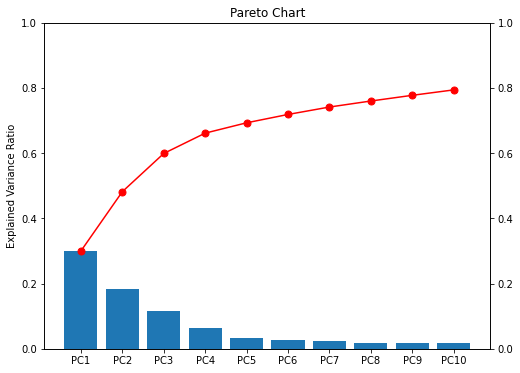

In [ ]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(all_features)

explained_variance = pca.explained_variance_ratio_
accumulated = pca.explained_variance_ratio_.cumsum()

pca_components = [("PC" + str(i)) for i in range(1,11)]

fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Pareto Chart")

ax.bar(pca_components, explained_variance)
ax.set_ylim([0, 1])
ax.set_ylabel("Explained Variance Ratio")

ax2 = ax.twinx()
ax2.plot(pca_components, accumulated, color="red", marker="o", ms=7)
ax2.set_ylim([0, 1])

plt.show()

## 2 dimensions

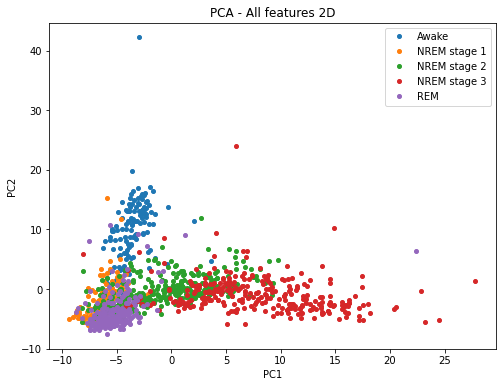

In [ ]:
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(energy_zero)
X_pca_2d = pd.DataFrame(X_pca_2d, columns=["PC1", "PC2"])

plot_2d("PCA - All features 2D", X_pca_2d, sleepstage_names, "sleepstage", ["PC1", "PC2"], 0)

## 3 dimensions

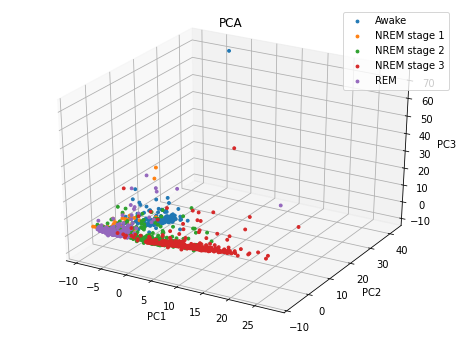

In [ ]:
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(energy_zero)
X_pca_3d = pd.DataFrame(X_pca_3d, columns=["PC1", "PC2", "PC3"])

plot_3d("PCA", X_pca_3d, sleepstage_names, "sleepstage", ["PC1", "PC2", "PC3"], 0)

# MDS

In [ ]:
metrics = ["euclidean", "chebyshev", "cityblock"]
m = metrics[0]
distance_matrix = pairwise_distances(variance, metric = m)

## 2 dimensions

Stress: 1588336.7723269826


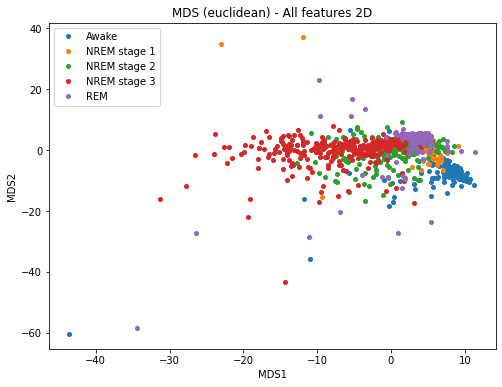

In [ ]:
mds_model = manifold.MDS(n_components=2, dissimilarity='precomputed', random_state=0)
X_mds_2d = mds_model.fit_transform(distance_matrix)
X_mds_2d = pd.DataFrame(X_mds_2d, columns=["MDS1", "MDS2"])

print("Stress:", mds_model.stress_)

plot_2d("MDS " + "("+m+") - All features 2D", X_mds_2d, sleepstage_names, "sleepstage", ["MDS1", "MDS2"], 0)

## 3 dimensions

Stress: 589390.9063802607


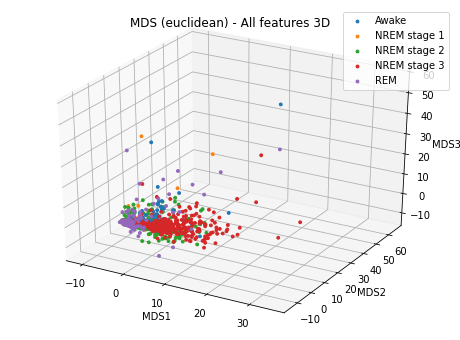

In [ ]:
mds_model = manifold.MDS(n_components=3, dissimilarity='precomputed', random_state=0)
X_mds_3d = mds_model.fit_transform(distance_matrix)
X_mds_3d = pd.DataFrame(X_mds_3d, columns=["MDS1", "MDS2", "MDS3"])

print("Stress:", mds_model.stress_)

plot_3d("MDS " + "("+m+") - All features 3D", X_mds_3d, sleepstage_names, "sleepstage", ["MDS1", "MDS2", "MDS3"], 0)

# Clustering

## Parameters

In [ ]:
n_clusters = 5

X_2d = X_pca_2d
X_3d = X_pca_3d

In [ ]:
def clustering_evaluation(labels_true, labels_cluster):
  
  db = davies_bouldin_score(labels_true, labels_cluster)

  labels_true = [p[0] for p in labels_true.to_numpy()]
  hcv = homogeneity_completeness_v_measure(labels_true, labels_cluster)

  print("Homogeneity score:", round(hcv[0],4))
  print("Completeness score:", round(hcv[1],4))
  print("V-Measure:", round(hcv[2],4))
  print("Davies-Bouldin score:", round(db,4))


  # ACCURACY
  cm = confusion_matrix(labels_true, labels_cluster)
  
  # Permutation maximizing the sum of the diagonal elements
  row_ind, col_ind = linear_sum_assignment(-cm)
  cm2 = cm[:,col_ind]
  a = np.trace(cm2) / np.sum(cm2)

  print("Accuracy:", np.round(a, 4), "\n")

  fig, ax = plt.subplots(1,2, figsize=(15,5))
  sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=ax[0])
  sns.heatmap(cm2, annot=True, cmap="Reds", fmt="d", cbar=False, ax=ax[1])
  ax[0].set_title('Confusion matrix')
  ax[0].set_xlabel('Estimated cluster')
  ax[0].set_ylabel('True label')
  ax[1].set_title('Reordered confusion matrix')
  ax[1].set_xlabel('Predicted label')
  ax[1].set_ylabel('True label')
  plt.show()

## K-Means

### 2 dimensions

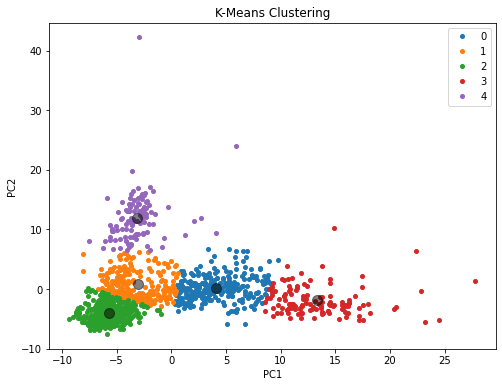

In [ ]:
kmeans = KMeans(n_clusters = n_clusters).fit(X_2d)
kmeans_labels = kmeans.labels_
centers = kmeans.cluster_centers_

labels = pd.DataFrame(kmeans_labels, columns=["cluster"])

plot_2d("K-Means Clustering", X_2d, labels, "cluster", ["PC1", "PC2"], centers)

Homogeneity score: 0.437
Completeness score: 0.4374
V-Measure: 0.4372
Davies-Bouldin score: 6.3477
Accuracy: 0.5333 



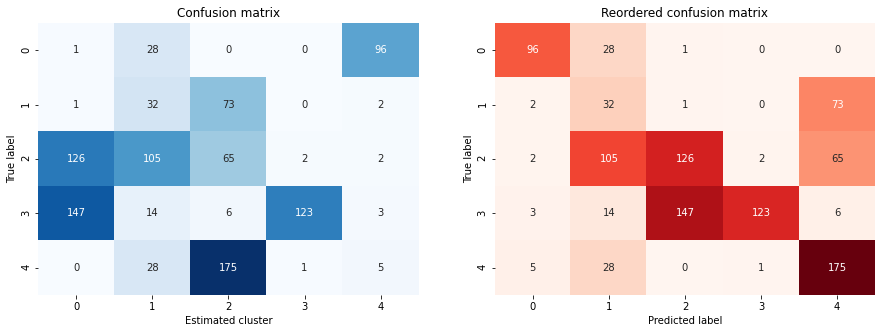

In [ ]:
clustering_evaluation(sleepstage, kmeans_labels)

### 3 dimensions

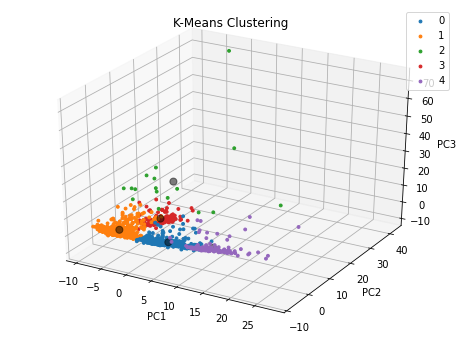

In [ ]:
kmeans = KMeans(n_clusters = n_clusters).fit(X_3d)
kmeans_labels = kmeans.labels_
centers = kmeans.cluster_centers_

labels = pd.DataFrame(kmeans_labels, columns=["cluster"])

plot_3d("K-Means Clustering", X_3d, labels, "cluster", ["PC1", "PC2", "PC3"], centers)

Homogeneity score: 0.4438
Completeness score: 0.5281
V-Measure: 0.4823
Davies-Bouldin score: 6.9974
Accuracy: 0.5855 



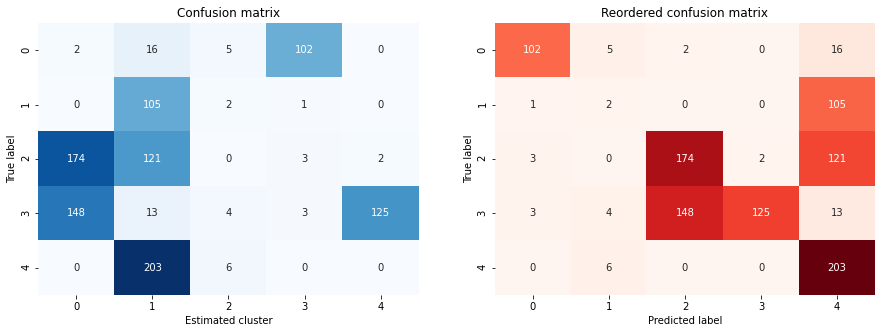

In [ ]:
clustering_evaluation(sleepstage, kmeans_labels)

## Agglomerative clustering

In [ ]:
linkage = ["ward", "complete", "average", "single"]
affinity = ["euclidean", "l1", "l2", "manhattan", "cosine"]

### 2 dimensions

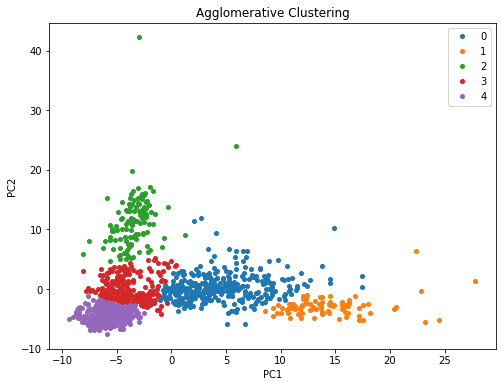

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage="ward").fit(X_2d)
agglomerative_labels = agglomerative.labels_

labels = pd.DataFrame(agglomerative_labels, columns=["cluster"])

plot_2d("Agglomerative Clustering", X_2d, labels, "cluster", ["PC1", "PC2"], 0)

Homogeneity score: 0.444
Completeness score: 0.4531
V-Measure: 0.4485
Davies-Bouldin score: 3898.1567
Accuracy: 0.5401 



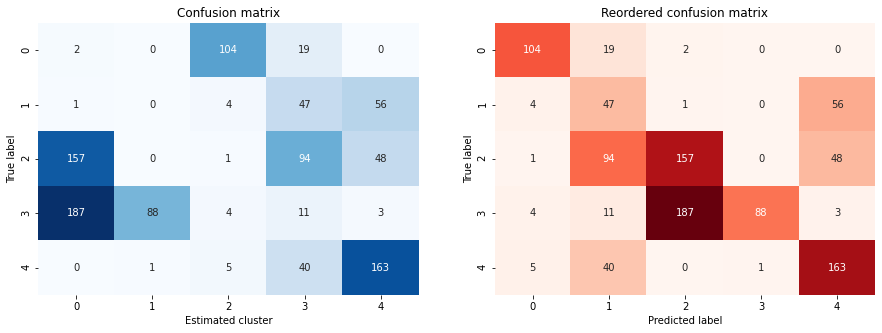

In [ ]:
clustering_evaluation(sleepstage, agglomerative_labels)

### 3 dimensions

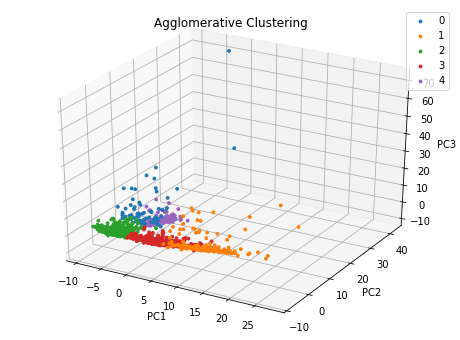

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage="ward").fit(X_3d)
agglomerative_labels = agglomerative.labels_

labels = pd.DataFrame(agglomerative_labels, columns=["cluster"])

plot_3d("Agglomerative Clustering", X_3d, labels, "cluster", ["PC1", "PC2", "PC3"], centers)

Homogeneity score: 0.4568
Completeness score: 0.4917
V-Measure: 0.4736
Davies-Bouldin score: 4.3212
Accuracy: 0.6203 



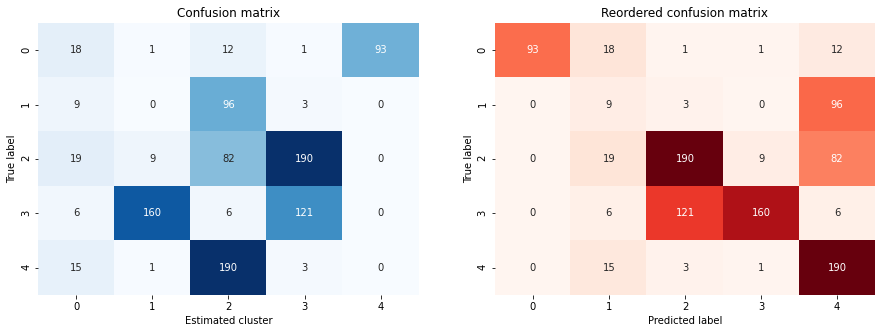

In [ ]:
clustering_evaluation(sleepstage, agglomerative_labels)

## K-Medoids 

### 2 dimensions


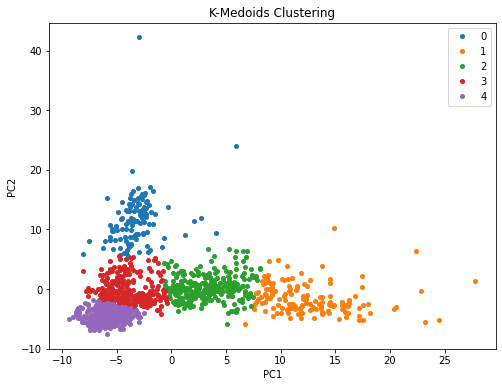

In [ ]:
kmedoids = KMedoids(n_clusters = n_clusters).fit(X_2d)
kmedoids_labels = kmedoids.labels_
centers = kmedoids.cluster_centers_

labels = pd.DataFrame(kmedoids_labels, columns=["cluster"])

plot_2d("K-Medoids Clustering", X_2d, labels, "cluster", ["PC1", "PC2"], centers)

Homogeneity score: 0.4543
Completeness score: 0.4456
V-Measure: 0.4499
Davies-Bouldin score: 7.8442
Accuracy: 0.5826 



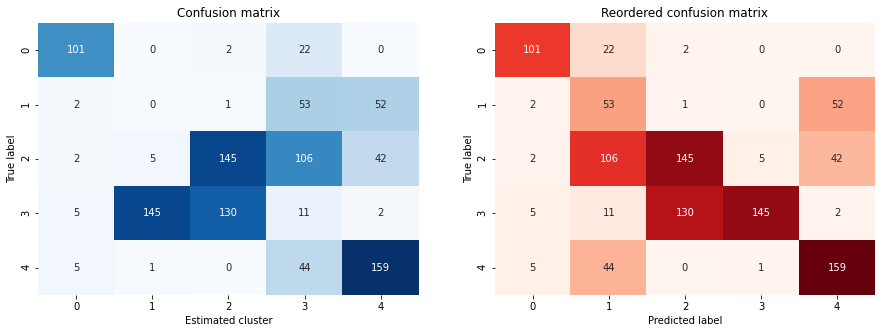

In [ ]:
clustering_evaluation(sleepstage, kmedoids_labels)

### 3 dimensions

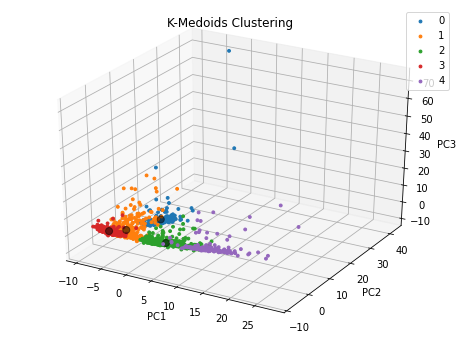

In [ ]:
kmedoids = KMedoids(n_clusters = n_clusters).fit(X_3d)
kmedoids_labels = kmedoids.labels_
centers = kmedoids.cluster_centers_

labels = pd.DataFrame(kmedoids_labels, columns=["cluster"])

plot_3d("K-Medoids Clustering", X_3d, labels, "cluster", ["PC1", "PC2", "PC3"], centers)

Homogeneity score: 0.4714
Completeness score: 0.4705
V-Measure: 0.4709
Davies-Bouldin score: 4.3577
Accuracy: 0.5836 



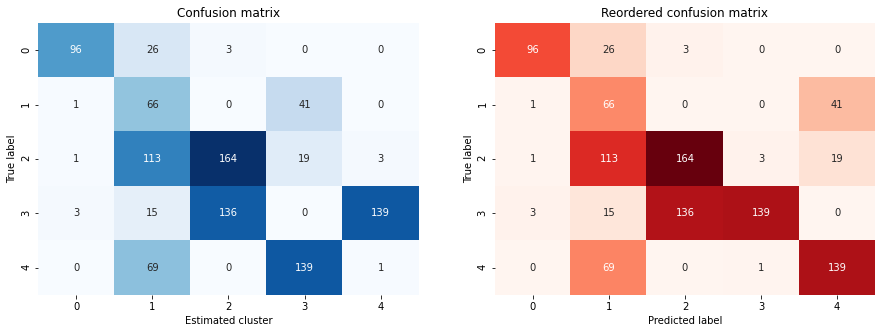

In [ ]:
clustering_evaluation(sleepstage, kmedoids_labels)